#### Smart City project:

This code is just to visualize json files.

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 500)
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import sklearn.svm as svm

%matplotlib inline

In [2]:
#SensorLog3001-12m.txt

#df = pd.read_csv('SensorLog3001-12m.txt', sep=",", header=None)  #Reading a json file into panda df.
data = np.loadtxt("SensorLog3001-12m.txt",dtype='str',delimiter=',')
#dataset=pd.read_csv("SensorLog3001-12m.txt", header=None, engine='python', sep=',', names=None, 
#                index_col=None, usecols=None, squeeze=False)

#dataset.head()

#print(np.shape(data))

dataset = pd.DataFrame({'House_Number': data[:, 0], 'Sensor_num': data[:, 1], 'Status': data[:, 2], 'Day': data[:, 3], 'Month': data[:, 4], 'Year': data[:, 5], 'Hour': data[:, 6], 'Min': data[:, 7], 'Counter': data[:, 8], 'Time_elapsed': data[:, 9]}
                      , columns=['House_Number', 'Sensor_num', 'Status','Day','Month', 'Year', 'Hour', 'Min', 'Counter','Time_elapsed' ])

dataset.head(40)

header = list(dataset)

print(header)
# Creating an empty Dataframe with column names only
dummy_df = pd.DataFrame(columns=header)

#bed = dataset[Sensor_num='Sensor 5']

#bed = dataset[dataset['Sensor_num']=='Sensor 8']

status = dataset.Status.values


for i,state in enumerate(status):
    if state=='ABS Bed Sensor Occupied':
        status[i]= 1
    elif state=='ABS Bed Sensor Vacated':
        status[i]= 2
    elif state=="Pat's Bedroom Motion Activated":   
        status[i]= 0
    elif state=="Chair Sensor Occupied":   
        status[i]= 0
    elif state=="Living Room Motion Activated":   
        status[i]= 0
    #elif 'Idle' in state:  
    #    status[i]= np.nan
    #elif 'Vacated' in state:  
    #    status[i]= np.nan
    else:
        status[i]=np.nan

        
dataset.drop('Status', axis = 1, inplace = True)

dataset['Status'] = status

dataset = dataset.dropna()


bed = dataset
bed.head()

['House_Number', 'Sensor_num', 'Status', 'Day', 'Month', 'Year', 'Hour', 'Min', 'Counter', 'Time_elapsed']


,House_Number,Sensor_num,Day,Month,Year,Hour,Min,Counter,Time_elapsed,Status
8,Res3001,Sensor 7,23,10,2017,10,25,625,14,0
13,Res3001,Sensor 7,23,10,2017,10,29,629,0,0
16,Res3001,Sensor 7,23,10,2017,10,35,635,0,0
18,Res3001,Sensor 7,23,10,2017,10,38,638,0,0
22,Res3001,Sensor 5,23,10,2017,10,50,650,3,0


In [3]:
bed_data = bed.drop(['House_Number','Sensor_num','Year','Hour','Min'], axis = 'columns')
bed_data[['Status','Day','Month','Counter','Time_elapsed']] = bed_data[['Status','Day','Month','Counter','Time_elapsed']].astype(int)

bed_data_24 = bed_data[(bed_data['Day']==24) & (bed_data['Month']==10)]
#bed_data_24 = bed_data[bed_data['Day']==24]

bed_data_24 = bed_data_24.drop(['Day','Month','Time_elapsed'], axis = 'columns')

#print(type(count[0]))


#ax.set_xlabel('Count')
#ax.set_ylabel('Status')

#bed_data_24.head(100)

def data_preprocess(df,date):
    
    timer = np.linspace(0,1440,1441)
    dummy_status = np.zeros(1441)
    day = np.zeros(1441)


    #This loop check the data of a day and within each 30 second period, it checks the status and
    #assign it to a new location in the dummy_status. Within each 30 s, it gives prority to bed sensor being active
    #Next prority is for waking up and set rest to 0.
    for i,val in enumerate(timer):

        bed_data = df[df['Counter'].between(timer[i], timer[i]+0.5)]
        #print(bed_data.Counter.values)
        if len(bed_data.Counter.values) == 0 :
            dummy_status[i] = 0
        elif 1 in bed_data.Status.values:
            dummy_status[i] = 1
        elif 2 in bed_data.Status.values:
            dummy_status[i] = 2
        else:
            dummy_status[i] = 0

    #print(bed_data)

    #This loop get rid of 0s before waking up and setting to sleep(=1)
    for i in range(np.size(dummy_status)):

        if dummy_status[i]!=2:
            dummy_status[i] = 1
            break
    #This loop set 1s for short naps           
    for i in range(np.size(dummy_status)-1):

        if dummy_status[i]==1 and dummy_status[i+1]==0:
            dummy_status[i+1] = 1

    #This loop remove 2s by replacing with a 1 (Just before getting up considered as sleeping)
    for i in range(np.size(dummy_status)):
        if dummy_status[i]==2:
            dummy_status[i] = 1
        day[i]=date

    if np.mean(dummy_status)> 0.7:
        #dummy_status = np.array(dummy_status)
        dummy_status = dummy_status.fill(np.nan)
        #dummy_status1=dummy_status.fillna()
        
    dummy_df = pd.DataFrame(columns=['Day','Counter','Status'])
    dummy_df['Day'] = day
    dummy_df['Counter'] = timer
    dummy_df['Status'] = dummy_status

    return dummy_df
    #return day, timer, dummy_status

#day, timer, dummy_status = data_preprocess(bed_data_24,24)
#ax = df.plot.scatter(x='Counter',y='Status',alpha=0.5)

#print(day)

#df.head()
#x = bed_data_24.Counter.values
#y = bed_data_24.Status.values          


In [4]:
day_list = np.linspace(1,31,31)

df_final = pd.DataFrame(columns=['Day','Counter','Status'])

#This loop goes through all days of a given month and add all the dataframes into one.
for date in day_list:

    bed_data_oneday = bed_data[(bed_data['Day']==int(date)) & (bed_data['Month']==7)]
    #bed_data_24 = bed_data[bed_data['Day']==24]

    bed_data_oneday = bed_data_oneday.drop(['Day','Month','Time_elapsed'], axis = 'columns')
    
    df_processed = data_preprocess(bed_data_oneday,int(date))
    df_final = pd.concat([df_final, df_processed])
    
    
df_final.head(2000) 

df_final = df_final.dropna()
    
df_final.to_csv('file1.csv')   

In [41]:
bed_data = pd.read_csv('file1.csv',dtype={"Counter": np.int32, "Status": np.int32}, index_col=[0]) 

#y = bed_data.Status
#X = bed_data.Counter

#print(y)
#print(X)


#Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.5, random_state = 0)

#print(Xtrain.values)
bed_data.head()

,Day,Counter,Status
0,3.0,0,1
1,3.0,1,1
2,3.0,2,1
3,3.0,3,1
4,3.0,4,1


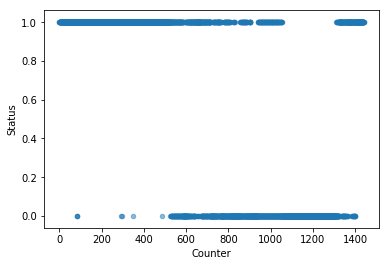

In [42]:
odd_days = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]

#odd_days = [1]
#even_days = [4]


odd_data = bed_data[bed_data['Day'].isin(odd_days)]

#odd_data.head(100)

even_data = bed_data[~bed_data['Day'].isin(odd_days)]
#even_data = bed_data[bed_data['Day'].isin(even_days)]

even_data.head(2000)

ax = odd_data.plot.scatter(x='Counter',y='Status',alpha=0.5)


In [62]:
y = odd_data.Status
X = odd_data.Counter


S = svm.SVC(C=10,kernel='rbf',gamma=1)
#S = svm.SVC(C=10,kernel='poly',gamma=10,class_weight='balanced',degree=4)
S.fit(X.values.reshape(-1,1),y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [63]:
y_test = even_data.Status
X_test = even_data.Counter

y_pred=S.predict(X_test.values.reshape(-1,1))
#print(y_pred)

for i in y_pred:
    print(i)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [64]:
from sklearn.metrics import recall_score, make_scorer, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax,cm



#ax,cm = plot_confusion_matrix(y_test, y_pred, classes= np.array([0,1]))


Confusion matrix, without normalization


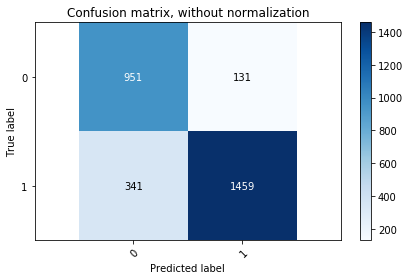

In [65]:
ax,cm = plot_confusion_matrix(y_test, y_pred, classes= np.array([0,1]))

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score

# Create the model with 100 trees
#model = RandomForestClassifier(n_estimators=100, 
#                               bootstrap = True,
#                               max_features = 'sqrt')
# Fit on training data
#model.fit(X.values.reshape(-1,1), y)

# places to store optimal models and scores
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):


    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True, n_jobs =8)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

        print(gsearch.best_params_)


        #plot.grid_search(gsearch.grid_scores_, change='n_estimators', kind='bar')
        #plt.show()

    # no grid search, just cross-val score for given model   
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)

    return model, cv_score, grid_results

model = 'RandomForest'
opt_models[model] = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators':[40,60,100,150,200,300],'min_samples_split':[2,4,6],'max_features':['auto', 'sqrt'],'max_depth': [20, 40, 60, 80, 100, None]}

clf, cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,splits=5, repeats=1, X = X.values.reshape(-1,1), y = y)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   31.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   48.8s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  1.1min finished


{'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 6, 'n_estimators': 300}
----------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
----------------------
score= 0.8977561878325238
rmse= 0.3197558633824817
cross_val: mean= 0.3956906280180826 , std= 0.005756469228610022


[1 1 1 ... 1 1 1]
Confusion matrix, without normalization
Training accuracy: 0.8362248438584317
Training precision: 0.9176100628930818
Training recall: 0.8105555555555556


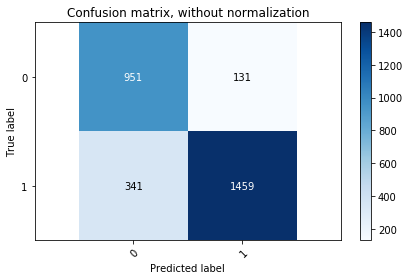

In [72]:
y_pred=clf.predict(X_test.values.reshape(-1,1))
print(y_pred)
ax,cm = plot_confusion_matrix(y_test, y_pred, classes= np.array([0,1]))

def get_accuracies(cm):

    tn = cm[0,0]
    fp = cm[0,1]
    tp = cm[1,1]
    fn = cm[1,0]
    

    # Training Accuracy
    trainacc = (tp+tn)/(tp+tn+fp+fn)
    
    print('Training accuracy:', trainacc)


    # Precision
    precision = tp /(tp+fp)
    
    print('Training precision:', precision)
    
    #Recall
    recall = tp /(tp+fn)
    
    print('Training recall:', recall)
    

    
    
get_accuracies(cm)

In [15]:
import torch
from IPython.display import clear_output

def live_plot(X, y, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.scatter(X[y==0,0], X[y==0,1], color='red')
    plt.scatter(X[y==1,0], X[y==1,1], color='blue')
    plt.scatter(X[y==2,0], X[y==2,1], color='green')
    plt.title(title)
    plt.show()

y = odd_data.Status
X = odd_data.drop('Status', axis = 'columns')

X = X.values
y = y.values

y_test = even_data.Status
X_test = even_data.drop('Status', axis = 'columns')

X_test = X_test.values
y_test = y_test.values

class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, max_iter=1000, lr=1e-3):
        
        super().__init__()
        
        # Neural Network Architecture: 40 hidden units 
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=40*num_classes)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=40*num_classes, out_features=40*num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        self.dense3 = torch.nn.Linear(in_features=40*num_classes, out_features=num_classes)
        self.activation3 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X

    
num_features = X.shape[1]
num_classes = 2
max_iter = 10000
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

Xt = torch.FloatTensor(X)
yt = torch.LongTensor(y)

for i in range(max_iter):
    optimizer.zero_grad()
    y_pred = model(Xt)
    loss = criterion(input=y_pred, target=yt)
    loss.backward()
    optimizer.step()
    #if i % 100 == 0:
    #    with torch.no_grad():
    #        live_plot(y_pred.detach().numpy(), y, title=f"Loss at epoch {i}: {loss.item():.4f}")
            
with torch.no_grad():
    y_pred = model.forward(Xt)
    y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
    print(f"Classifier Accuracy: {accuracy_score(y_true=y, y_pred=y_pred) * 100}%")

    
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
y_pred=model(X_test)
print(y_pred)
#ax,cm = plot_confusion_matrix(y_test, y_pred, classes= np.array([0,1]))

Classifier Accuracy: 57.39070090215128%
tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        ...,
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], grad_fn=<LogSigmoidBackward>)


In [16]:
model.eval()
y_pred = model(X_test)
after_train = criterion(y_pred.squeeze(), y_test)
print('Test loss after Training' , after_train.item())

print(y_pred)

final_pred = np.argmax(y_pred.data.numpy(), axis=1)

print(final_pred)

for i in final_pred:
    
    print(i)

Test loss after Training 0.6931387186050415
tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        ...,
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], grad_fn=<LogSigmoidBackward>)
[0 0 0 ... 0 0 0]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


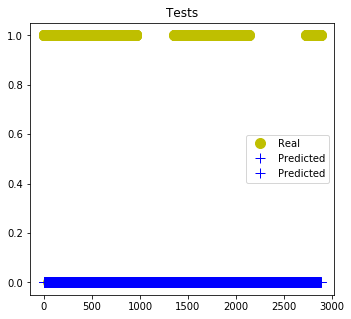

In [17]:
def plotcharts():
    #errors = np.array(errors)
    #plt.figure(figsize=(12, 5))
    #graf02 = plt.subplot(1, 2, 1) # nrows, ncols, index
    #graf02.set_title('Errors')
    #plt.plot(errors, '-')
    #plt.xlabel('Epochs')
    plt.figure(figsize=(12, 5))
    graf03 = plt.subplot(1, 2, 2)
    graf03.set_title('Tests')
    a = plt.plot(y_test.numpy(), 'yo', label='Real')
    plt.setp(a, markersize=10)
    a = plt.plot(y_pred.detach().numpy(), 'b+', label='Predicted')
    plt.setp(a, markersize=10)
    plt.legend(loc=7)
    plt.show()
plotcharts()